In [ ]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
!mkdir speechcommands
!tar -xf speech_commands_v0.01.tar.gz -C /content/speechcommands


#Cambios

--2020-06-25 15:43:05--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.217.128, 2607:f8b0:400c:c13::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.217.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   101MB/s    in 13s     

2020-06-25 15:43:18 (105 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [ ]:
import librosa
import glob
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import Audio
from librosa.display import specshow

Obtener todos los archivos en un directorio usando glob:

In [ ]:
no_wavs = glob.glob('speechcommands/no/*.wav')
yes_wavs = glob.glob('speechcommands/yes/*.wav')

Con librosa puedo abrir uno de los audios. SR es la frecuencia de muestreo (sampling rate) y nos indica cuántas muestras de audio hay en un segundo. Usando sr=None mantenemos la frecuencia de muestreo original del audio

In [ ]:
x,sr = librosa.core.load(no_wavs[2],sr=None)

Lo que obtenemos al abrir el .wav es un vector con valores entre -1 y 1. Podemos graficarlo:

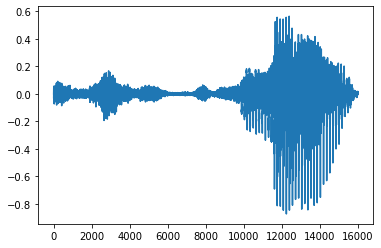

In [ ]:
plt.plot(x)

También podemos escucharlo:

In [ ]:
Audio(x,rate=sr)

In [ ]:
sr

16000

En este caso, la frecuencia de muestreo es de 16000 Hz o 16 kHz. Un CD de música normalmente tiene una frecuencia de muestreo de 44.1 o 48 kHz. A qué se deben estas diferencias?

El [teorema de Nyquist](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem) nos dice que la máxima frecuencia que podemos representar utilizando una frecuencia de muestreo $fs$ es $\frac{fs}{2}$

En el caso del habla, no producimos mucha información por encima de 8 kHz, por lo cual utilizar una $fs=16kHz$ será suficiente para que se entiendan las consonantes por ejemplo. En el caso de la música, notaremos que le falta brillo si utilizamos $fs=16kHz$, ya que muchos instrumentos musicales producen una cantidad importante de energía por encima de 8 kHz. El ser humano con un oído muy sano, en promedio escucha hasta 20 kHz, por lo cual, con utilizar $fs=44.1\:kHz$ nos aseguramos de que no se perderá espectro audible.

### Extracción de atributos de audio

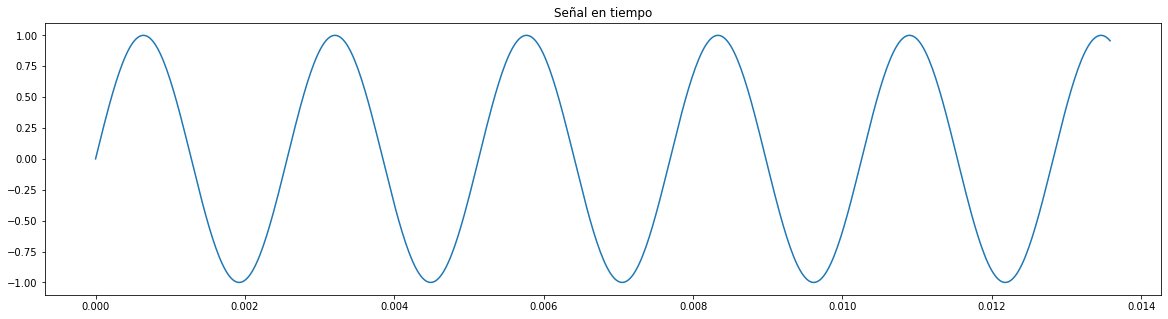

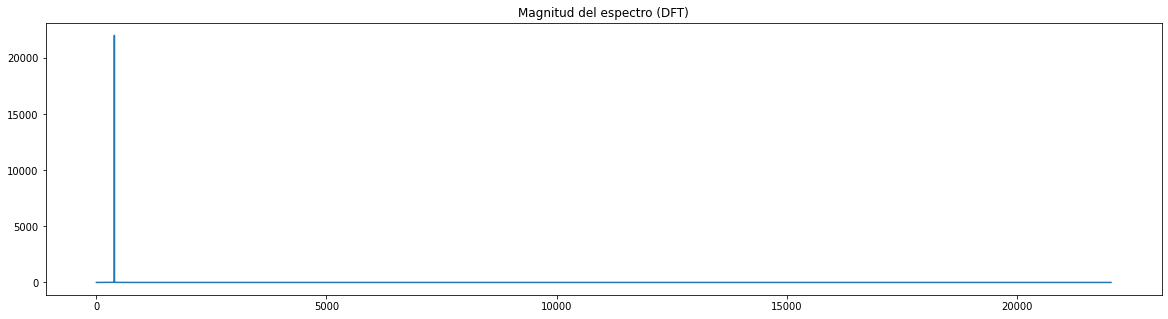

In [ ]:
#@title Frecuencia y fase

freq = 390 #@param {type:"slider", min:150, max:20000, step:20}
phase = 0 #@param {type:"slider", min:0, max:6.28, step:0.1}
sr_sin = 44100

t = np.linspace(0,1,sr_sin)
f = np.linspace(0,sr_sin/2,sr_sin//2+1)
y = np.sin(freq*2*np.pi*t + phase)
spectrum = np.fft.rfft(y)

plt.figure(figsize=(20,5))
plt.title('Señal en tiempo')
plt.plot(t[:600],y[:600])
plt.figure(figsize=(20,5))
plt.title('Magnitud del espectro (DFT)')
plt.plot(f,np.abs(spectrum))
Audio(y,rate=sr_sin)

### Representaciones tiempo-frecuencia - Espectrogramas

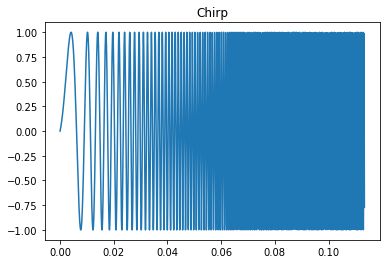

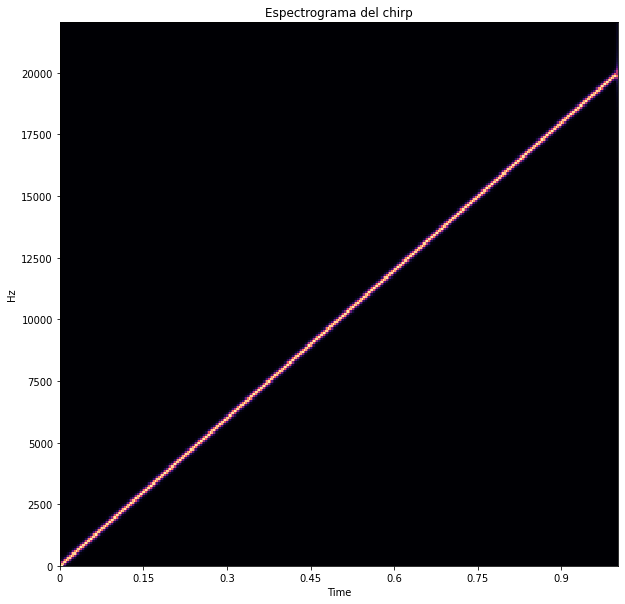

In [ ]:
from librosa.display import specshow

fmin = 20
fmax = 20000

chirp = np.sin(0.5*2*np.pi*(fmax-fmin)*t**2 + t*2*np.pi*fmin)
plt.plot(t[:5000],chirp[:5000])
plt.title('Chirp')
Audio(chirp,rate=sr_sin)

winsize=512
hopsize=128

t_spec = np.arange(0,sr_sin,hopsize)/sr_sin
f_spec = np.linspace(0,sr_sin//2,winsize//2-1)

spectrogram = librosa.stft(chirp,n_fft=winsize,hop_length=hopsize,win_length=winsize)
mag_spectrogram = np.abs(spectrogram)

plt.figure(figsize=(10,10))
plt.title('Espectrograma del chirp')
specshow(mag_spectrogram,sr=sr_sin,hop_length=hopsize,y_axis='linear',x_axis='time')
Audio(chirp,rate=sr_sin)

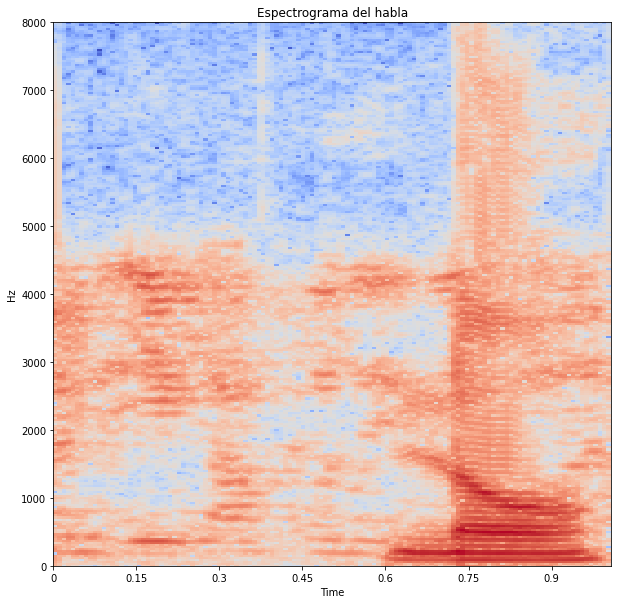

In [ ]:
spectrogram = librosa.stft(x,n_fft=winsize,hop_length=hopsize,win_length=winsize)
mag_spectrogram = np.abs(spectrogram)

plt.figure(figsize=(10,10))
plt.title('Espectrograma del habla')
specshow(10*np.log10(mag_spectrogram),sr=16000,hop_length=hopsize,y_axis='linear',x_axis='time',vmin=-50)
Audio(x,rate=16000)

Un espectrograma es una 'imagen' muy grande. Una forma de achicarlo es teniendo en cuenta que el oído humano no es muy bueno discriminando frecuencias que se encuentran muy cerca entre si. Y a medida que la frecuencia es más alta, por nuestra percepción en escala logarítmica, somos peores discriminando. Por esto se puede agrupar energía de frecuencias cercanas utilizando la llamada **escala mel** y asi achicar el eje de frecuencias.

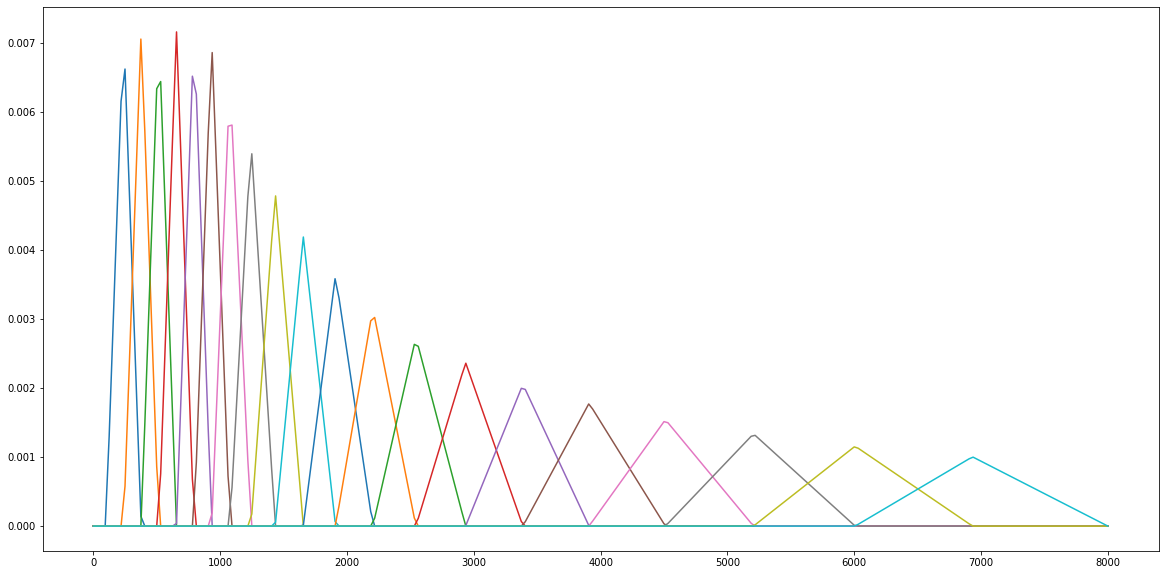

In [ ]:
plt.figure(figsize=(20,10))

for filt in librosa.filters.mel(16000,winsize,n_mels=20,fmin=100):
  plt.plot(np.linspace(0,sr//2,winsize//2+1),filt)

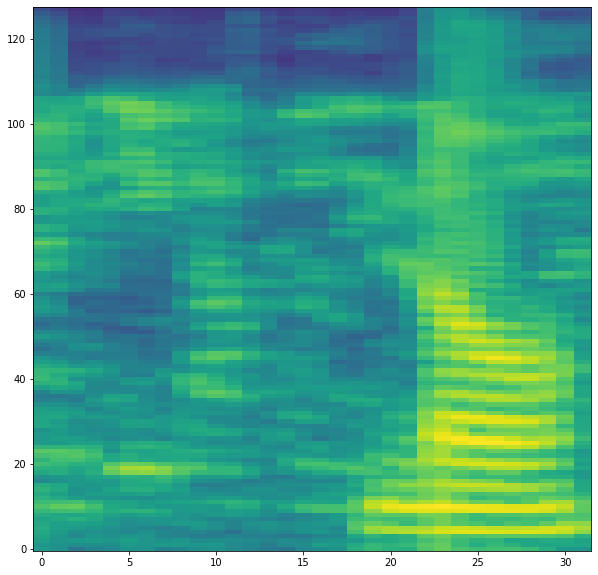

In [ ]:
melspec = librosa.feature.melspectrogram(x)
plt.figure(figsize=(10,10))
plt.imshow(10*np.log10(melspec),aspect='auto',origin='bottom',vmin=-80)

Ya redujimos bastante la dimensionalidad de los datos, sin embargo, todavía falta. Analicemos un poco como funciona la voz humana: 

###Modelo Fuente-Filtro

![alt text](https://www.researchgate.net/profile/Pedro_Gomez2/publication/283309010/figure/fig1/AS:614183339053073@1523444127922/Fants-source-filter-model-of-speech-production-the-excitation-signal-en-may-be.png)

![alt text](https://www.researchgate.net/profile/Jacques_Koreman/publication/265566668/figure/fig1/AS:669469168922639@1536625296282/Source-filter-model-of-speech-production.png)

Lo que nos interesa no es si dije una palabra mas o menos agudo para distinguirla. Las palabras son invariantes al pitch. La información útil está en las formantes, que están dadas por el filtro del tracto vocal.

El espectro del habla $H(\omega)$ que observamos es una multiplicación del espectro de la fuente $S(\omega)$ y el espectro del filtro $F(\omega)$.

Ahora si calculamos el espectro del espectro (más precisamente del logaritmo del espectro), lo que tenemos es el **cepstrum**:

$Cepstrum(x) = DFT(log(DFT(x(t))))$

Si observamos $S(\omega)$ como si fuera una señal en el tiempo, podemos ver que cambia más rápido que $F(\omega)$, por ende, tiene componentes de frecuencia más altas. Es por esto que las primeras componentes del cepstrum (que serían la baja quefrency), dan información de $F(\omega)$ y la estructura de los formantes, mientras que las componentes altas del cepstrum poseen información de pitch y relaciones entre armónicos.

![alt text](https://www.researchgate.net/profile/Ruben_Fraile/publication/26335113/figure/fig1/AS:394516591857666@1471071493515/Graphical-interpretation-of-cepstrum.png)

Los coeficientes cepstrales en frecuencia mel (MFCCs) son los coeficientes del cepstrum, calculado sobre espectros en escala mel, y usando DCT (transformada discreto coseno) en vez de DFT.
Como en habla nos interesan las formantes, se suelen usar las primeras 12 junto con la energía. A su vez, para estos 13 atributos, se calcula sus diferencias de primer y segundo orden, dando lugar a 39 atributos.

Normalmente, para reconocimiento del habla, estas 39 features, las cuales forman secuencias, son modeladas usando cadenas ocultas de Markov (HMM). En este trabajo práctico usaremos random forests, y para resumir estas 39 secuencias, calcularemos la media y desvío estándar, dando lugar a 78 atributos finales.

### MFCC + energía

Text(0.5, 1.0, '12 MFCCs + Energia')

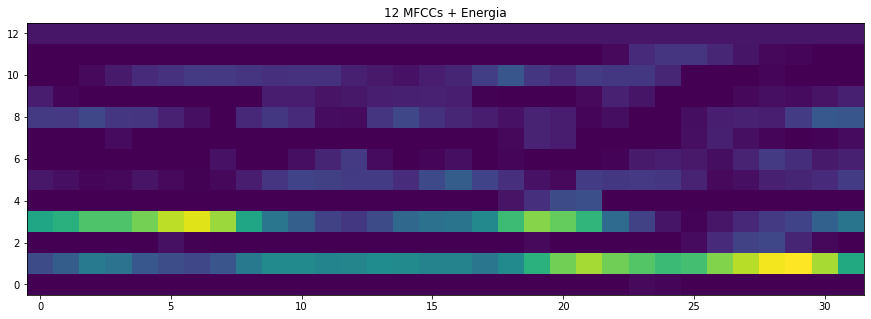

In [ ]:
mfccs = librosa.feature.mfcc(x,sr=sr,n_mfcc=12)
energy = librosa.feature.rmse(x)
features = np.concatenate([mfccs,energy])
plt.figure(figsize=(15,5))
plt.imshow(features,aspect='auto',origin='bottom',vmin=-10)
plt.title('12 MFCCs + Energia')

### $\Delta$

Text(0.5, 1.0, '$\\Delta$MFCC y energía')

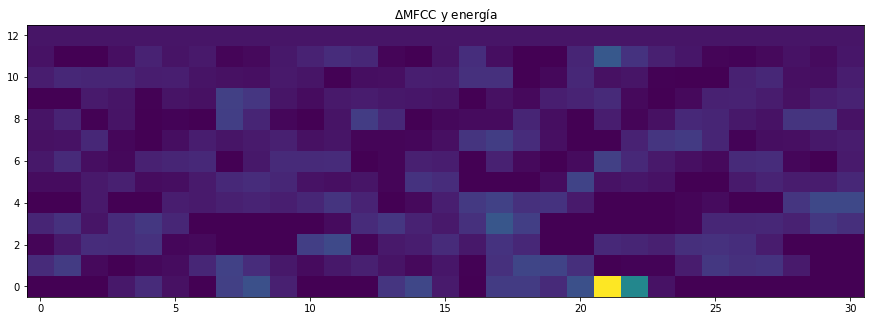

In [ ]:
delta_features = np.diff(features,axis=1)
plt.figure(figsize=(15,5))
plt.imshow(delta_features,aspect='auto',origin='bottom',vmin=-10)
plt.title('$\Delta$MFCC y energía')

### $\Delta\Delta$

Text(0.5, 1.0, '$\\Delta\\Delta$MFCC y energía')

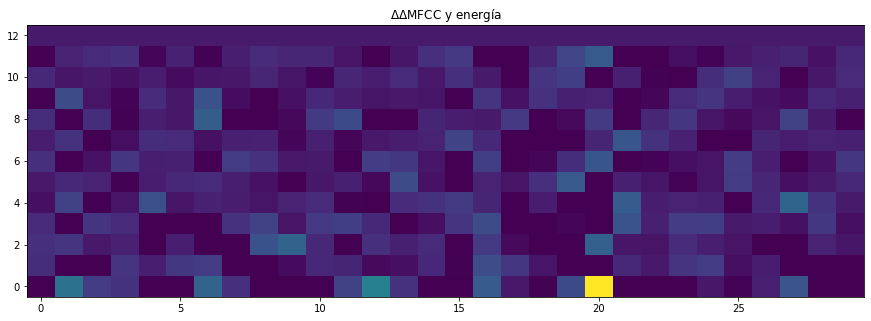

In [ ]:
deltadelta_features = np.diff(delta_features,axis=1)
plt.figure(figsize=(15,5))
plt.imshow(deltadelta_features,aspect='auto',origin='bottom',vmin=-10)
plt.title('$\Delta\Delta$MFCC y energía')

### Funcionales

In [ ]:
features_mean = np.mean(features,axis=1)
features_std = np.std(features,axis=1)
deltafeatures_mean = np.mean(delta_features,axis=1)
deltafeatures_std = np.std(delta_features,axis=1)
deltadeltafeatures_mean = np.mean(deltadelta_features,axis=1)
deltadeltafeatures_std = np.std(deltadelta_features,axis=1)

all_features = np.concatenate([features_mean,features_std,deltafeatures_mean,deltafeatures_std,
                              deltadeltafeatures_mean,deltadeltafeatures_std])

### La función importante para el TP:

La siguiente función va a extraer los descriptores para poder ser utilizados en los modelos de machine learning:

In [ ]:
def calculate_features(filename, n_mfcc=12,delta=True,deltadelta=True,energy=True, summary_fn = [np.mean, np.std], summary_names=['mean','std']):
  #Abro el archivo:
  x, sr = librosa.core.load(filename,sr=None)
  
  #Calculo MFCCs
  features = librosa.feature.mfcc(x,sr=sr,n_mfcc=n_mfcc)
  feat_names = ['mfcc_{}'.format(i) for i in range(n_mfcc)]
  #Calculo energia:
  if energy:
    energy = librosa.feature.rmse(x)
    features = np.concatenate([features,energy])
    feat_names = feat_names + ['energy']
  #Aplico media y desvio estandar por defecto
  summary_features = np.concatenate([fn(features,axis=1) for fn in summary_fn])
  feat_names = ['{}_{}'.format(name_i,summ_i) for summ_i in summary_names for name_i in feat_names]
  
  #Lo mismo con los delta
  if delta:
    deltafeatures = np.diff(features)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltafeatures,axis=1) for fn in summary_fn])])
    d_names = ['d{}'.format(name) for name in feat_names]
  else:
    d_names = []

  #Y con los delta de segundo orden
  if deltadelta:
    deltadeltafeatures = np.diff(features,n=2)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltadeltafeatures,axis=1) for fn in summary_fn])]) 
    dd_names = ['dd{}'.format(name) for name in feat_names]
  else:
    dd_names = []

  feat_names = feat_names + d_names + dd_names
  
  return summary_features, feat_names  

In [ ]:
feat, names = calculate_features(yes_wavs[0])

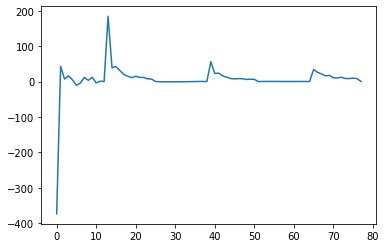

In [ ]:
plt.plot(feat)

In [ ]:
import numpy as np

t = np.linspace(0,1,44100)
audio = np.sin(1200*t)

In [ ]:
ruido = np.random.normal(size=audio.shape)
senal = ruido + audio

In [ ]:
ruidoaudio, sr = librosa.core.load('speechcommands/_background_noise_/doing_the_dishes.wav', sr=None)

In [ ]:
ruidoaudio = ruidoaudio[5000:5000+len(audio)]

In [ ]:
Audio(0.5*ruidoaudio + audio,rate=44100)

In [ ]:
with open('speechcommands/testing_list.txt','r') as f:
  test_idxs = f.read().splitlines()

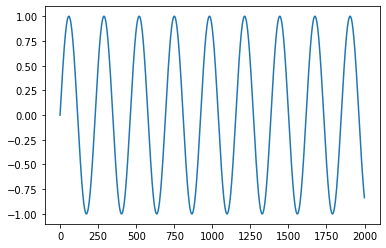

In [ ]:
plt.plot(audio[:2000])

### Grupos

In [ ]:
import pandas as pd

alumnos = pd.read_excel('AA20.xlsx',header=2).iloc[:79][['COM','APELLIDO Y NOMBRES']]
comision1 = alumnos[alumnos['COM'] == 'C1']
comision2 = alumnos[alumnos['COM'] == 'C2']

n_gruposc1 = [4]*10
n_gruposc2 = [4]*9 + [3]

seed = 1234

for i, (n, com) in enumerate(zip([n_gruposc1,n_gruposc2],[comision1,comision2])):
  print('\nComision {}\n'.format(i+1))
  com = com.set_index('APELLIDO Y NOMBRES')
  for i, n_integrantes in enumerate(n):
    integrantes = com.sample(n=n_integrantes,random_state=seed).index
    com = com.drop(integrantes)
    print('Grupo {}'.format(i+1))
    print(list(integrantes))


Comision 1

Grupo 1
['CORIA, Leandro Ariel', 'XIFRO, Ramiro Martín', 'GAMBOA, Javier', 'BADARO, Sebastián']
Grupo 2
['ELIASCHEV,  Laura Sandra', 'VILLANUEVA, Cecilia Azul', 'IANNONE, Julián Ignacio', 'BENITEZ, Carlos Marcelo']
Grupo 3
['FERREYRA VILLANUEVA, María José', 'GENOVA, Cristian Ezequiel', 'CILLO, Gabriel Carlos', 'CASTAÑO, María Guadalupe']
Grupo 4
['LOPEZ, Antonella Ayelén', 'CHAMORRO, Luciano Leonel', 'TESTORI, Franco', 'DAZA CARO, Yudi Carolina']
Grupo 5
['MASSARO ROCCA, Patricio Nicolás', 'ROMERO VICTORICA, Matias', 'CISCO, Nicolás', 'FIGUEIRO, Gabriel Hernán']
Grupo 6
['ISKOWITZ, Facundo', 'RYAN, Tomás', 'FLIGUER, Federico Javier', 'TAGUCHI, Diana Noemí']
Grupo 7
['TREBOTIC, Gisel Denise', 'SCENNA, Federico Ignacio', 'AMIGO, Jesica Denise', 'TADEO, Florencia']
Grupo 8
['QUARRACINO, Luciana', 'RADICE, Marina', 'VILLALBA, Ricardo Demián', 'MEHAUDY, Martín']
Grupo 9
['MUES, Claudina', 'LOREDO, Rodrigo', 'RATTI FARRELL, Ian', 'CHIESA, Sebastian']
Grupo 10
['PAEZ PRESS, Xime

In [ ]:
groupnames = {'groupname': ['TP2-G{}-C{}'.format(grupo,comision) for grupo in range(1,11) for comision in range(1,3)]}
pd.DataFrame(groupnames).to_csv('nombregrupos.csv')

### Ejemplo de segmentación basada en energía

In [ ]:
import librosa
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np

El audio original consiste de palabras separadas por silencio. La idea es que puede ser más fácil grabar todas las palabras de un tirón y después recortarlas que grabar una por una. Recuerden que los atributos y el modelo fueron calculados con una determinada frecuencia de muestreo. Los audios que graben deberan tener esa misma frecuencia de muestreo para que todo sea compatible.

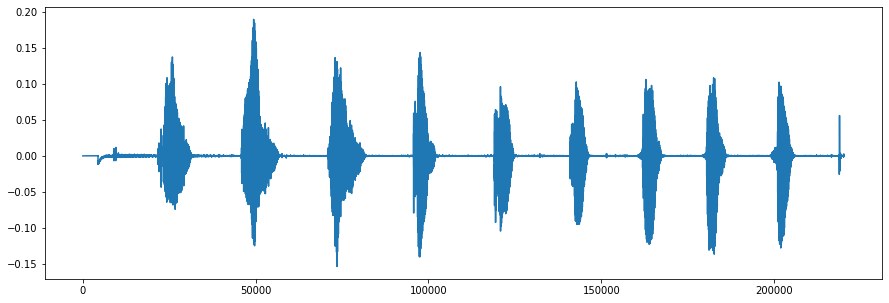

In [ ]:
x, fs = librosa.core.load('20200630_001.m4a',sr=16000)
display(Audio(x,rate=fs))
plt.figure(figsize=(15,5))
plt.plot(x)

Con el siguiente código tomamos la señal original y la separamos en sus palabras. El criterio es que todo lo que se encuentre top_db dB por debajo del máximo de la señal será considerado silencio. El valor de top_db deberán ajustarlo de acuerdo al rango dinámico de la señal. En este caso 20 dB es un valor adecuado. Para chequear si separa bien podemos ejecutar la siguiente celda, la cual nos mostrará un gráfico en el que cada segmento identificado tendrá un color distinto, y a su vez podremos escuchar cada segmento para verificar que está bien. Si estuviera mal es cuestión de ajustar el valor de top_db. En este caso, hay que descartar el primer y último segmento que son ruidos que se colaron en la grabación.

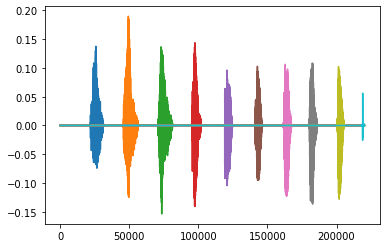

In [ ]:
split_points = librosa.effects.split(x,top_db=20)
for split in split_points:
  xplot = np.zeros_like(x)
  xplot[split[0]:split[1]] = x[split[0]:split[1]]
  plt.plot(xplot)
  display(Audio(x[split[0]:split[1]],rate=fs))

Una vez que estamos contentos con la segmentación podemos guardar los audios:

In [ ]:
!pip install soundfile
import soundfile as sf

for i,split in enumerate(split_points[1:-1]):
  sf.write('Segmento_{}.wav'.format(i),x[split[0]:split[1]],fs)


Finalmente podemos verificar que se hayan guardado bien los wavs:

In [ ]:
Audio('Segmento_4.wav')